In [1]:
# 1. Import libraries:
%matplotlib inline
import os
import quandl
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib as mlp
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as spo
from scipy.stats import kurtosis, skew
import seaborn as sns
mlp.style.use('seaborn')
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',20)
from sklearn.preprocessing import StandardScaler

/var/folders/dk/mxqr91nj7135zkb7ptp3mq5c0000gn/T/ipykernel_36311/1196709035.py:14: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mlp.style.use('seaborn')


In [2]:
sp_url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
sp500 = pd.read_html(sp_url, header=0)[0]
sp500.head()


,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [3]:
#  Correct invalid dates:
sp500.loc[sp500[sp500['Date added']=='1983-11-30 (1957-03-04)'].index,'Date added'] = '1983-11-30'
sp500.loc[sp500[sp500['Date added']=='2001?'].index,'Date added'] = '2001-01-01'
# Filter firms that entered the index after December 2015:
sp500['Date added'] = pd.to_datetime(sp500['Date added'],format='%Y-%m-%d')
sp500 = sp500[sp500['Date added']<'2007-01-01']
print("The number of stocks in the universe is:", sp500.shape[0])

The number of stocks in the universe is: 241


In [4]:
n_stocks = 5
np.random.seed(2)
universe_tickers = sp500['Symbol'].unique()
tickers = list(np.random.choice(universe_tickers,replace=False,size=n_stocks))
print(tickers)

['BK', 'CTAS', 'T', 'CSCO', 'MRK']


In [5]:
# # 'data' will be a Pandas DataFrame containing the historical data for the specified tickers
def download_data(tickers, start_date, end_date, columns):
    data = yf.download(tickers, start=start_date, end=end_date)
    data=data[columns]
    return data

# Define the tickers, start date, end date, and columns you want to download
# tickers = ['AAPL', 'GOOGL', 'MSFT']
start_date = '2007-01-01'
end_date = '2022-12-31'
columns = [ 'Adj Close']

# Download the data
data = download_data(tickers, start_date, end_date, columns)
# print(data)


def one_lvl_colnames(df,cols,tickers):
    """This function changes a multi-level column indexation into a one level
    column indexation

    Inputs:
    -------
    df (pandas Dataframe): dataframe with the columns whose indexation will be 
        flattened.
    tickers (list|string): list/string with the tickers (s) in the data frame df.
    cols (list|string): list/string with the name of the columns (e.g. 'Adj Close',
        'High', 'Close', etc.) that are in the dataframe df.
    
    Ouputs:
    -------
    df (pandas Dataframe): dataframe with the same information as df, but 
        with one level of indexation.
    """
    
    df_not_renamed=df.copy()
    # Define important variables:
    if isinstance(tickers, str):
        tickers = [tickers]
    if isinstance(cols, str):
        
        cols = [cols]
    # For multi-level column indexing:
    if isinstance(df.columns.values[0], tuple):

        # Define important varibles
        columns = df.columns.values
        new_cols = []

        # Itarate through the multi-level column names and flatten them:
        for col in columns:
            temp = []
            for name in col:
                if name != '':
                    temp.append(name)
            new_temp = '_'.join(temp)
            new_cols.append(new_temp)
        
        # Change the column names:
        df.columns = new_cols
#         print(df.columns)
    
    # For uni-level colum indexing:
    elif isinstance(df.columns.values[0], str):
        
        # Define new names:
        col_names = [column+'_'+ticker for column in cols\
                     for ticker in tickers]
        df.columns = col_names
    
#     print("the dataframe after the columns have been renamed") 
#     print(df)

    return df


df2=pd.DataFrame(one_lvl_colnames(data,cols=columns,tickers=tickers))
df2_columns=list(df2.columns)
df2.columns = [col.replace('Adj Close', 'close') for col in df2_columns]
df2.reset_index(inplace=True)

df2['weekday'] = df2['Date'].dt.dayofweek
df2=df2[df2['weekday']==0].reset_index(drop=True)
df2.drop(columns=['weekday'],inplace=True)
df2=df2.set_index('Date')
df2.tail()


[*********************100%%**********************]  5 of 5 completed


,close_BK,close_CSCO,close_CTAS,close_MRK,close_T
Date,,,,,
2022-11-21,43.078899,46.203724,446.185455,102.798195,17.654074
2022-11-28,43.223621,46.650047,450.829285,105.562584,17.635332
2022-12-05,42.490364,47.862873,455.860138,107.081055,17.569740
2022-12-12,43.271858,47.833759,453.885498,106.068741,18.085117
2022-12-19,42.615788,45.990265,440.083008,107.232025,16.735764


In [6]:
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import mean_absolute_error as mae 
import pandas as pd 
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

In [7]:

def sma(data, n):
    sma_values=[]
    for i in range(len(data)):
        if i>=n:
            sma=sum(data[i-n:i])/n
            sma_values.append(sma)
            
        else:
            sma_values.append(None)
            
    return sma_values

In [8]:
def ema(data, n):
    ema_values=[]
    alpha=2/(n+1)
    for i in range(len(data)):
        if i==n-1:
            ema=data[i-1]
            ema_values.append(ema)
        elif i>=n:
            ema=alpha*data[i-1]+(1-alpha)*ema
            ema_values.append(ema)
        else:
            ema_values.append(None)
            
    return ema_values

In [9]:
from sklearn.model_selection import train_test_split
train_size=0.9
train,test=train_test_split(df2,train_size=train_size,shuffle=False)
test

,close_BK,close_CSCO,close_CTAS,close_MRK,close_T
Date,,,,,
2021-05-10,48.270718,49.329742,351.844238,68.927689,20.451710
2021-05-17,48.104496,49.125591,344.109558,70.426682,19.661972
2021-05-24,47.781273,49.543171,346.553223,69.686005,18.646593
2021-06-07,47.855152,50.034981,338.987579,67.273849,18.226650
2021-06-14,45.841949,50.266968,345.302063,70.321999,18.232920
2021-06-21,45.860420,49.348301,354.617432,71.533638,18.132637
2021-06-28,46.968613,49.144154,371.038940,71.636169,18.038620
2021-07-12,46.432976,49.739079,383.237793,72.279266,18.285757
2021-07-19,43.939560,49.580223,370.051727,71.813255,17.842733


BK
CSCO
CTAS
MRK
T


,BK_close,BK_close_sma,BK_close_ema,BK_close_lag5,CSCO_close,CSCO_close_sma,CSCO_close_ema,CSCO_close_lag5,CTAS_close,CTAS_close_sma,CTAS_close_ema,CTAS_close_lag5,MRK_close,MRK_close_sma,MRK_close_ema,MRK_close_lag5,T_close,T_close_sma,T_close_ema,T_close_lag5
Date,,,,,,,,,,,,,,,,,,,,
2021-06-28,0.751788,0.590507,0.597715,0.621673,0.618714,0.642461,0.638122,0.618705,0.805082,0.559326,0.568436,0.428185,0.390408,0.420103,0.385741,0.484695,0.382529,0.306209,0.355233,0.243882
2021-07-12,0.584155,0.616530,0.649073,0.606235,0.709112,0.642462,0.631653,0.689046,0.730962,0.634705,0.647318,0.588703,0.425423,0.401245,0.387297,0.334941,0.460854,0.333938,0.364332,0.189854
2021-07-19,0.384820,0.612114,0.627433,0.645190,0.623963,0.646476,0.657473,0.696986,0.359619,0.663157,0.675199,0.429025,0.353830,0.419342,0.400005,0.223093,0.303550,0.388138,0.396506,0.310629
2021-07-26,0.936474,0.560040,0.546562,0.439634,0.894525,0.631871,0.646303,0.667542,0.698499,0.649275,0.570006,0.652316,0.395200,0.445489,0.384614,0.594058,0.462237,0.386723,0.365521,0.405459
2021-08-02,0.734507,0.659408,0.676533,0.639801,0.639732,0.677268,0.729044,0.540024,0.557601,0.658512,0.612837,0.698399,0.320058,0.405718,0.388143,0.463727,0.393729,0.398078,0.397759,0.381222


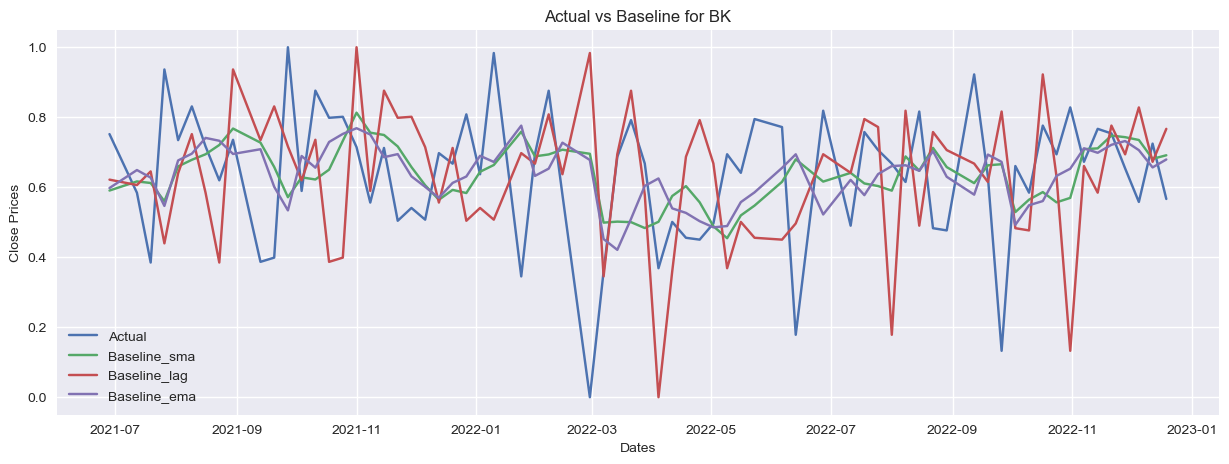

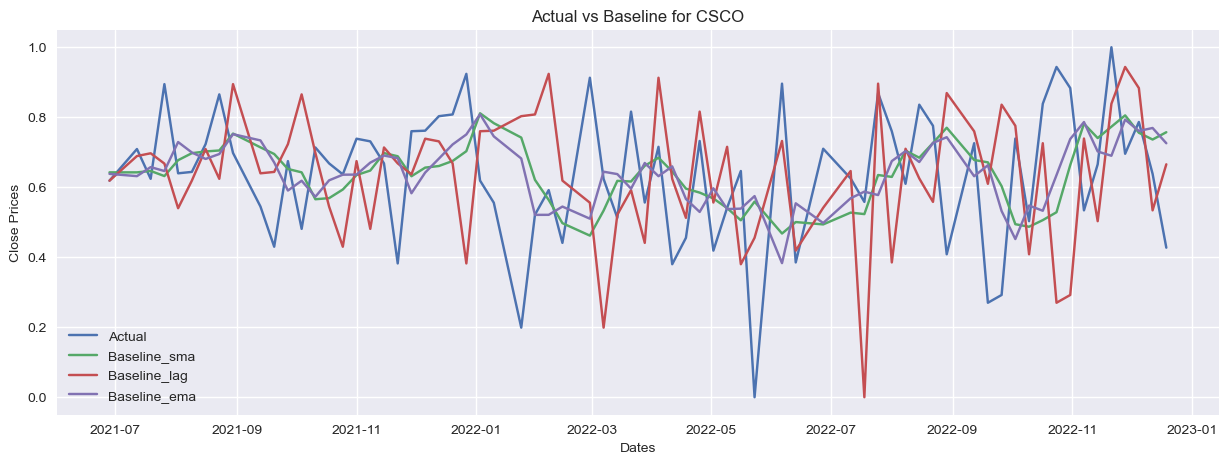

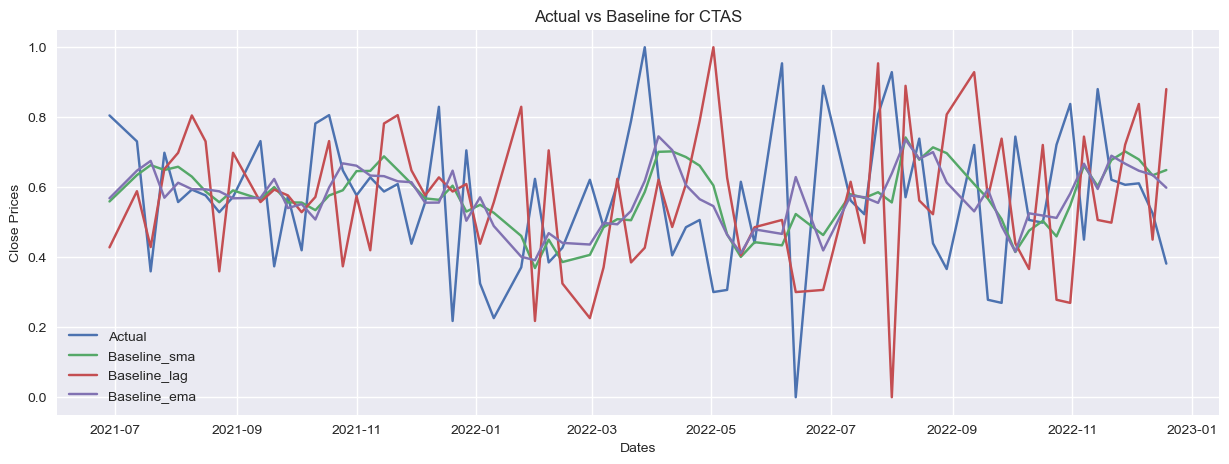

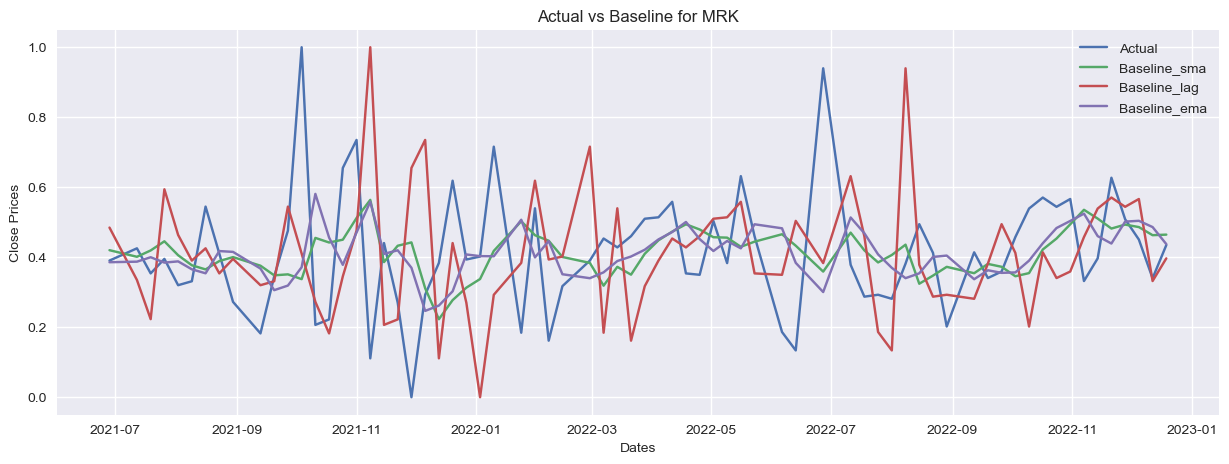

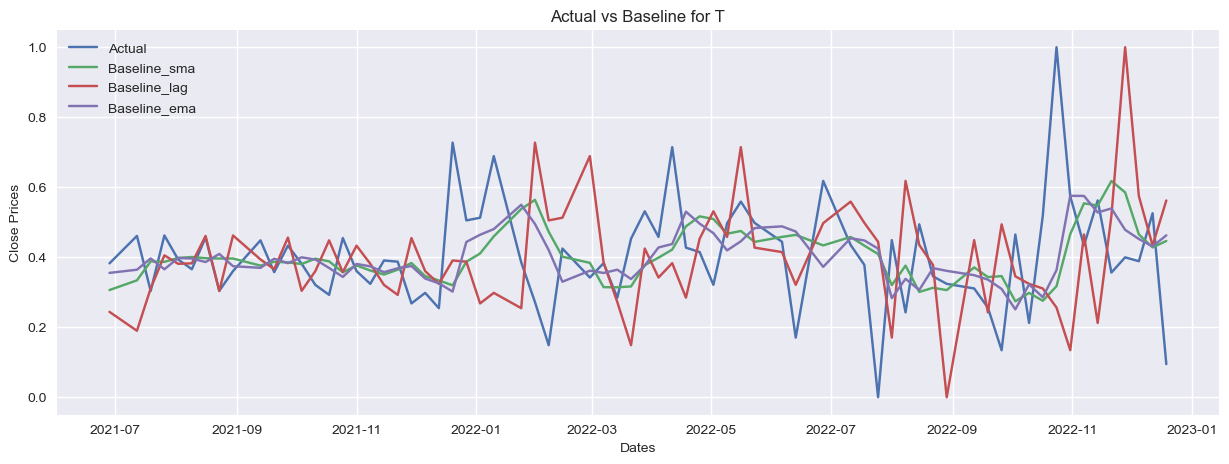

In [10]:
from stockstats import StockDataFrame
def extract_and_wrap_ticker_data(df, columns,n):
    # Split column names into parts
    parts = [col.split('_') for col in columns]

    # Create a dictionary to store information about each ticker
    ticker_info = {}

    # Iterate through the parts list
    for part in parts:
        data_type = part[0]  # e.g., 'Adj Close', 'Close', etc.
        ticker = part[1]     # e.g., 'AAPL', 'GOOGL', etc.

        # Check if the ticker is already in the dictionary
        if ticker not in ticker_info:
            ticker_info[ticker] = {}

        # Add information for the ticker
        ticker_info[ticker][data_type] = df[f'{data_type}_{ticker}']

    # Create a dictionary to store stockstats DataFrames for each ticker
    ticker_dataframes = pd.DataFrame()
    Dict={}

    # Iterate through ticker_info and wrap data with stockstats
    for ticker, data in ticker_info.items():
        Dict[ticker]={}
        df = pd.DataFrame(data)
        print(ticker)
        
        stock_df=df[['close']]
        stock_df['close']=stock_df['close'].pct_change(fill_method='ffill')
        
        sc=MinMaxScaler(feature_range=(0,1))
####################
        stock_df.fillna(0,inplace=True)
        stock_df.replace([np.inf,-np.inf],0,inplace=True)

        stock_df.bfill(inplace=True)
        stock_df.ffill(inplace=True)
        stock_df[stock_df.columns]=sc.fit_transform(stock_df)

        stock_df.head()
        
 #####################       
        stock_df['close_sma']=sma(stock_df['close'],n)
        stock_df['close_ema']=ema(stock_df['close'],n)
        stock_df['close_lag'+str(n)]=stock_df['close'].shift(n)
        
        stock_df=stock_df[n+1:]
        
        #calculate RMSE for SMA
        mse=mean_squared_error(stock_df['close'],stock_df['close_sma'])
        mae_sma=mae(stock_df['close'],stock_df['close_sma'])
        rmse_sma=np.sqrt(mse)
        Dict[ticker]['mae_sma']=mae_sma
        Dict[ticker]['rmse_sma']=rmse_sma
        
        #calculate RMSE for EMA
        rmse_ema=np.sqrt(mean_squared_error(stock_df['close'],stock_df['close_ema']))
        mae_ema=mae(stock_df['close'],stock_df['close_ema'])
        Dict[ticker]['mae_ema']=mae_ema
        Dict[ticker]['rmse_ema']=rmse_ema
        
        #calculate RMSE for lagged values
        rmse_lagged=np.sqrt(mean_squared_error(stock_df['close'],stock_df['close_lag'+str(n)]))
        Dict[ticker]['rmse_lagged']=rmse_lagged
        mae_lagged=mae(stock_df['close'],stock_df['close_lag'+str(n)])
        Dict[ticker]['mae_lagged']=mae_lagged
        
        #Plot learning rate vs epoch
        stock_df_grph=stock_df[-90:]
        stock_df_grph.reset_index(inplace=True)
        plt.figure(figsize=(15,5))
        
        
        plt.plot(stock_df_grph['Date'],stock_df_grph['close'], label='Actual')
        plt.plot(stock_df_grph['Date'],stock_df_grph['close_sma'], label='Baseline_sma')
        plt.plot(stock_df_grph['Date'],stock_df_grph['close_lag'+str(n)], label='Baseline_lag')
        plt.plot(stock_df_grph['Date'],stock_df_grph['close_ema'], label='Baseline_ema')
        plt.xlabel('Dates')
        plt.ylabel('Close Prices')
        plt.legend()
        plt.title(f'Actual vs Baseline for {ticker}')
        
        
        stock_df.columns=[f'{ticker}_{i}' for i in stock_df.columns]
        
        ticker_dataframes=pd.concat([ticker_dataframes,stock_df],axis=1)
        
        
    return Dict,ticker_dataframes

# Sample DataFrame with specified columns
columns = list(df2.columns)



# Extract and wrap ticker data
periods=5
perf_dict,ticker_dataframes = extract_and_wrap_ticker_data(test, columns, periods)

ticker_dataframes.head()

In [11]:
output=pd.DataFrame(perf_dict).T
# output['Index'] = output.index
# output.reset_index(inplace=True)

# Calculate the average of all values in the DataFrame
average_values = output.mean()
# average_row = pd.DataFrame([average_values], columns=output.columns)
output.loc['Average'] = average_values
print(output)
# Append the new row to the original DataFrame
# output = output.append(average_row, ignore_index=True)
output

          mae_sma  rmse_sma   mae_ema  rmse_ema  rmse_lagged  mae_lagged
BK       0.166875  0.212555  0.160778  0.210466     0.282049    0.217343
CSCO     0.163093  0.207848  0.160313  0.203777     0.258188    0.200011
CTAS     0.174469  0.217463  0.167743  0.214381     0.300730    0.241702
MRK      0.142321  0.191571  0.139686  0.193701     0.249942    0.187555
T        0.122601  0.169963  0.116200  0.162646     0.229674    0.167991
Average  0.153872  0.199880  0.148944  0.196994     0.264117    0.202921


,mae_sma,rmse_sma,mae_ema,rmse_ema,rmse_lagged,mae_lagged
BK,0.166875,0.212555,0.160778,0.210466,0.282049,0.217343
CSCO,0.163093,0.207848,0.160313,0.203777,0.258188,0.200011
CTAS,0.174469,0.217463,0.167743,0.214381,0.300730,0.241702
MRK,0.142321,0.191571,0.139686,0.193701,0.249942,0.187555
T,0.122601,0.169963,0.116200,0.162646,0.229674,0.167991
Average,0.153872,0.199880,0.148944,0.196994,0.264117,0.202921


In [12]:
root_mean_squared_error: 0.0443 - mae: 0.0344

SyntaxError: invalid syntax (2255981433.py, line 1)